 # Práctica de aprendizaje automático (parte 2)

Entrega este cuaderno habiendo **ejecutado todas las celdas**. Incluye en la entrega **todos los ficheros necesarios para su ejecución**.

Asegúrate de que la presentación está bien estructurada: Se valorará la **claridad, concisión, y completitud** del informe.

Se trata de una práctica abierta: **sé intrépido y explora**. 

1. Describe las características de los datos:
    * Tipo de datos (e.g. [https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)))
    * Número de ejemplos de cada una de las clases.
    * Número y tipo (nominales no ordenados, nominales ordenados, numéricos) de atributos.

Esta información se debería utilizar en el análisis; por ejemplo, si se selecciona un atributo para la predicción, ¿es clara su relevancia por el tipo de información que proporciona de acuerdo con nuestro conocimiento experto sobre el área?
    
2. Detalla la metodología utilizada:
    * Partición de los datos: tamaño de los conjuntos de entrenamiento y test, uso de estratificación en el muestreo.
    * Preprocesamiento: codificación de los atributos, construcción y selección de características, normalización, etc. (¡solo se debe utilizar la información del conjunto de entrenamiento!)
    * Determinación de los hiperparámetros; por ejemplo, mediante búsqueda en rejilla y validación cruzada.
    * Estimación del error de generalización y su incertidumbre.
2. Resume los resultados en gráficas y tablas.
3. Elabora esta información e ilustra tus observaciones con los resultados obtenidos.
4. Proporciona una recomendación final:
    * Tipo de clasificador.
    * Configuración del clasificador (arquitectura, hiperparámetros, etc.) y método de entrenamiento (función de coste, método de optimización, uso de técnicas de regularización,...)
    * Para el predictor final, proporciona los errores de entrenamiento, validación cruzada y test.
5. Resume las conclusiones del análisis.

## 2. Construcción de un clasificador en una base de datos real (4.5 puntos)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn import datasets
from statistics import mean 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
df = pd.read_csv('./data/german_credit_data.csv', sep=';')
# Source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
# This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix

print(df.shape)
df.head(5)

(1000, 21)


,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [3]:
class_label = 'default'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['account_check_status ', 'duration_in_month ', 'credit_history ', 'purpose ', 'credit_amount ', 'savings ', 'present_emp_since ', 'installment_as_income_perc ', 'personal_status_sex ', 'other_debtors ', 'present_res_since ', 'property ', 'age ', 'other_installment_plans ', 'housing ', 'credits_this_bank ', 'job ', 'people_under_maintenance ', 'telephone ', 'foreign_worker']


**Estadísticos básicos de cada atributo:**

In [4]:
df.describe()

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,0.458487,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


**Datos codificados de forma numérica**

In [23]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']


**Histogramas suavizados de cada atributo en cada clase. El color indica la clase ("default"/"no default"):**

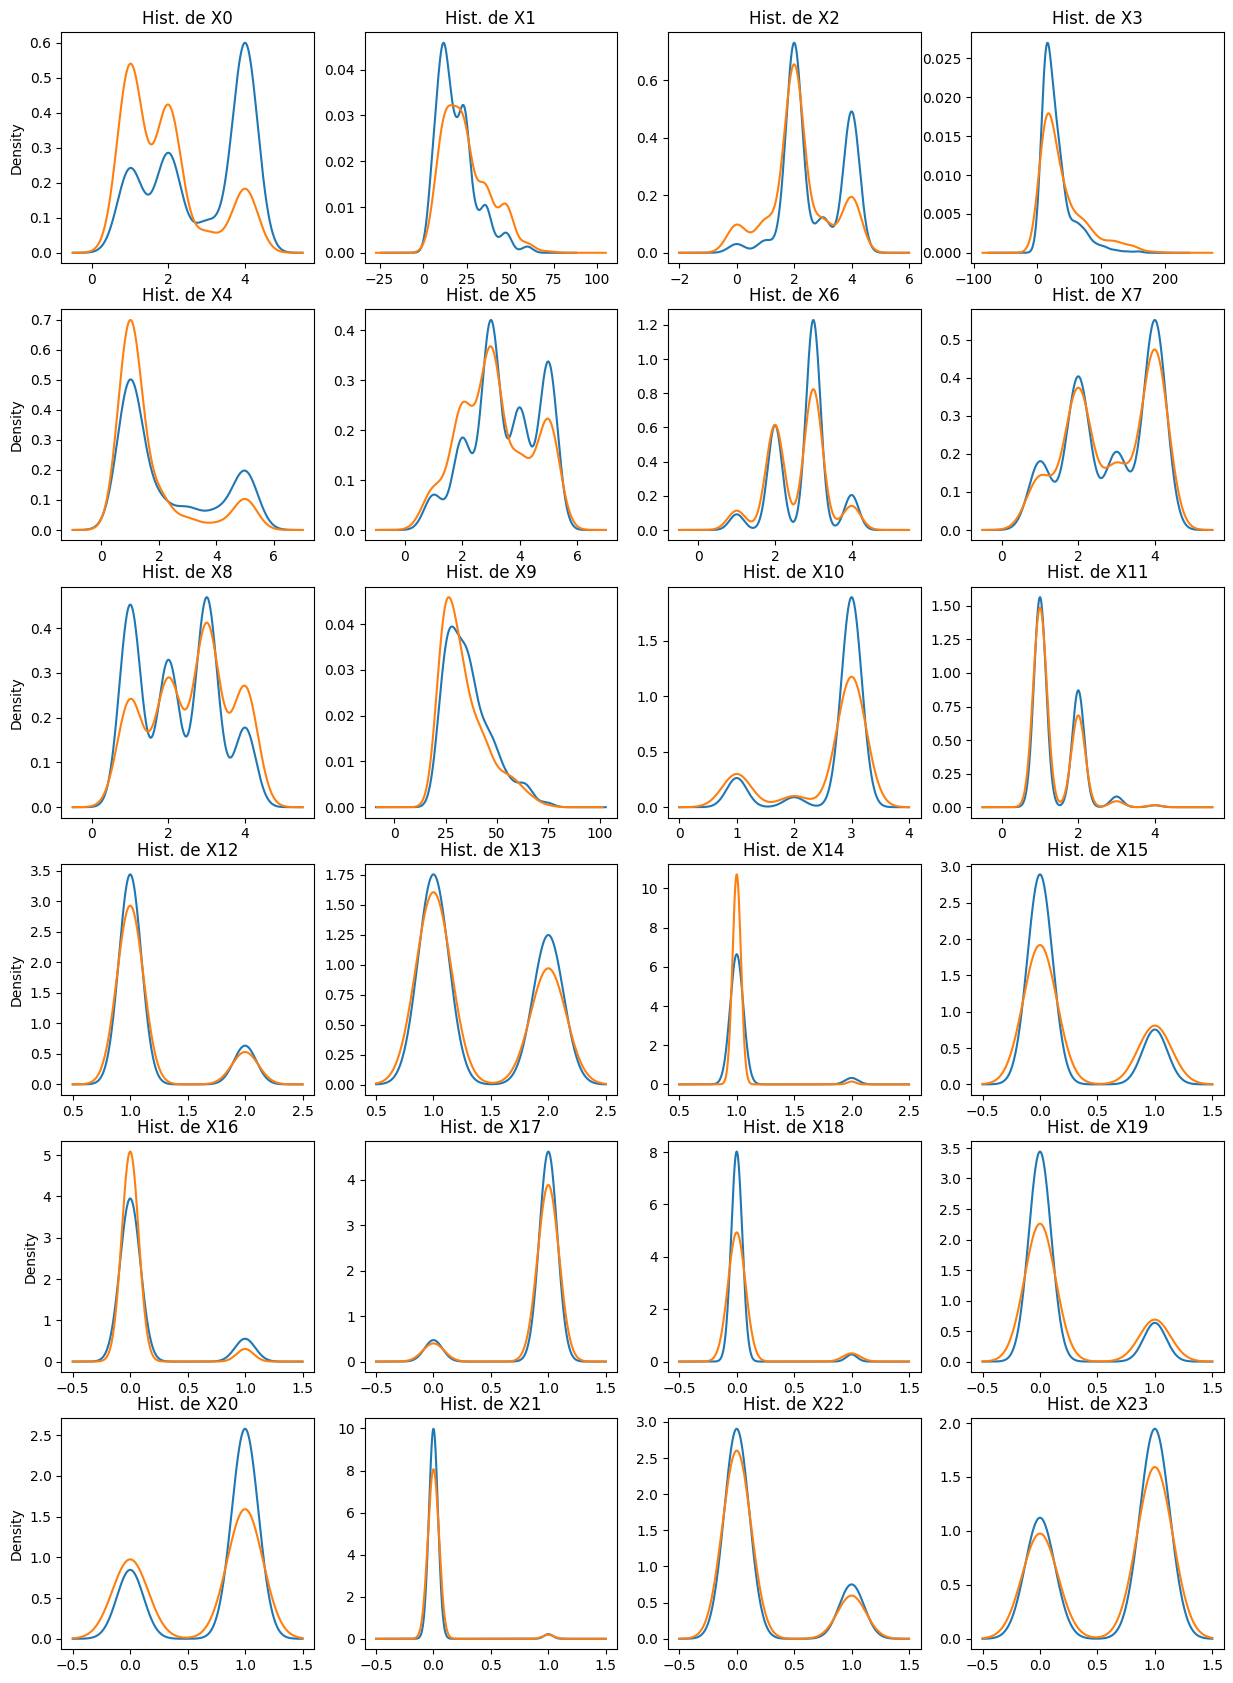

In [6]:
plt.figure(figsize=(15, 21))
n_cols_plot = 4
n_rows_plot = int(len(feature_names) / n_cols_plot)
for i,n in enumerate(feature_names):
    plt.subplot(n_rows_plot, n_cols_plot, i+1)
    aux = 'Density' if i%n_cols_plot == 0 else ''
    df.groupby('Class')[n].plot(kind='kde', title='Hist. de '+n)
    plt.ylabel(aux)

## Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation

La siguiente celda entrena un modelo y lo evalúa en varias particiones training-test diferentes de los datos. El resultado es un score medio junto a su desviación estándar. El tipo de modelo (Naïve Bayes / árbol de decisión / knn/ regresión logística / red neuronal) y parámetros empleados deberán ser seleccionados para que dicho resultado sea el mejor posible.

### Función que realiza el grid search de forma genérica

In [6]:

def train_n_check(grid_param, estimator):
    df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
    class_label = 'Class'
    feature_names = list(df.columns)
    feature_names.remove(class_label)
    X = df[feature_names].values
    y = df[class_label].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
    
    grid_search = GridSearchCV(estimator(), grid_param, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    param_names =  list(grid_param.keys())
    print("Estimación de grid search:")
    for param_name in param_names: 
        print("- "+param_name +" = ", str(grid_search.best_params_[param_name]))
    return grid_search.best_params_

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)


### Naïve Bayes
Se ha elegido var_smoothing porque es el único de los dos valores que tiene sentido ajustar para estos datos concretos

In [87]:
smooth_pow = 100
grid_param= {"var_smoothing": [i**(-i) for i in range(1,smooth_pow)]}
best_params = train_n_check(grid_param, GaussianNB)

clf = GaussianNB(var_smoothing= best_params['var_smoothing']) 
scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation


print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- var_smoothing =  0.00032
Precisión en cada una de las particiones:  [0.7   0.76  0.785 0.715 0.78 ]
Estimación de la precisión por validación cruzada: 0.75 +/- 0.03


### Arbol de Decisión
Se ha seleccionado max depth al ser el atributo más relevante de los árboles binarios (pues determina el número de reglas que hay como máximo antes de llegar a la conclusión sobre a que clase pertenece).


In [88]:
max_max_depth = 100
grid_param= {"max_depth": [i for i in range(1,max_max_depth)]}
best_params = train_n_check(grid_param, DecisionTreeClassifier)

clf = DecisionTreeClassifier(max_depth= best_params['max_depth'])
scores = cross_val_score(clf,  X, y, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- max_depth =  3
Precisión en cada una de las particiones:  [0.76 0.73 0.72 0.69 0.72]
Estimación de la precisión por validación cruzada: 0.72 +/- 0.02


### Knn Neighbors
N neighbors es el parámetro más relevante de este algoritmo pues "suaviza" los bordes con las distintas clases que hay en el data set.

In [89]:
max_knn = 100
grid_param= {"n_neighbors": [i for i in range(1,max_knn)]}
best_params = train_n_check(grid_param, KNeighborsClassifier)

clf = KNeighborsClassifier(n_neighbors=best_params['n_neighbors']) 
scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- n_neighbors =  7
Precisión en cada una de las particiones:  [0.735 0.74  0.72  0.66  0.71 ]
Estimación de la precisión por validación cruzada: 0.71 +/- 0.03


### Regresión Logística
De este algoritmo se ha elegido tol para comprobar si con mayor o menor tolerancia a parar la ejecución, la regresión mejora o empeora.

In [80]:
tol_pow = 10
tol_list= [i**(-i) for i in range(1,tol_pow)]

grid_param= {"tol":tol_list, "solver":["lbfgs"], "max_iter": [1000], "penalty":["l2"]}
best_params = train_n_check(grid_param, LogisticRegression)

clf = LogisticRegression(penalty=best_params['penalty'],
                         tol=best_params['tol'],
                         max_iter=best_params['max_iter'],
                        solver=best_params["solver"]) 
scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- tol =  1.0
- solver =  lbfgs
- max_iter =  1000
- penalty =  l2
Precisión en cada una de las particiones:  [0.7 0.7 0.7 0.7 0.7]
Estimación de la precisión por validación cruzada: 0.70 +/- 0.00


### Red Neuronal
Se han elegido los parametros hidden layer sizes (para ir probando distintas combinaciones de neuronas y capas). Para ello se ha creado una función que crea una lista con el mismo numero de listas en su interior que capas máximas haya y dentro de cada lista habrá todas las distintas capas neuronas que como máximo han sido indicadas en cada capa. Tras esto se permuta aleatoriamente cada lista y se seleccionan los primeros elementos, de esta manera hay la misma cantidad de muestras por capa.

In [18]:
import random

def random_create_n_select_layers(min_neurons, min_layers, max_neurons, max_layers, num_combinations):
    '''
    Crea aleatoriamente un conjunto entre unas neuronas y capas dadas
        (se ha de proporcionar también el número de combinaciones totales).
    '''
    combinations = [[(j,)*i for j in range(min_neurons, max_neurons+1)] for i in range(min_layers, max_layers+1)]
    
    each_layer = int(num_combinations/(max_layers-min_layers+1))

    final =list()

    for i in range(max_layers):
            prov_list = combinations[i][: (max_neurons-min_neurons+1)]
            random.shuffle(prov_list)
            final+=(prov_list[:each_layer])
        
    return final
            

In [19]:
max_neurons = 10

hidden_layer_sizes = [(i*10,) for i in range(1, max_neurons+1)]

grid_param= {"max_iter": [9000], "hidden_layer_sizes":hidden_layer_sizes,
             "alpha":[0.0], "solver":["lbfgs"]}

best_params = train_n_check(grid_param, MLPClassifier)
optimal_neurons = best_params["hidden_layer_sizes"]
scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))


Estimación de grid search:
- max_iter =  9000
- hidden_layer_sizes =  (10,)
- alpha =  0.0
- solver =  lbfgs
Precisión en cada una de las particiones:  [0.755 0.78  0.775 0.785 0.775]
Estimación de la precisión por validación cruzada: 0.77 +/- 0.01


In [33]:

min_neurons = optimal_neurons[0] 
max_neurons = optimal_neurons[0] + 2
min_layers = 1
max_layers = 5

hidden_layer_sizes = random_create_n_select_layers(min_neurons,min_layers,max_neurons,max_layers, 10)

grid_param= {"max_iter": [9000], "hidden_layer_sizes":hidden_layer_sizes,
             "alpha":[0.0], "solver":["lbfgs"]}

best_params = train_n_check(grid_param, MLPClassifier)

clf = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                    max_iter=best_params['max_iter'],
                    alpha=best_params['alpha'],
                    solver=best_params["solver"]) 

scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- max_iter =  9000
- hidden_layer_sizes =  (12,)
- alpha =  0.0
- solver =  lbfgs
Precisión en cada una de las particiones:  [0.74  0.785 0.775 0.76  0.745]
Estimación de la precisión por validación cruzada: 0.76 +/- 0.02


Da 12 por como se ha elegido el rango de las posibles neuronas y por el funcionamiento aleatorio de selección de "random_create_n_select_layers".

## Responde aquí a las siguientes preguntas:

* Haz una gráfica que muestre la dependencia de la precisión de un clasificador de vecinos próximos con el número de vecinos. Si es más conveniente, utiliza gráficas en escala logarítmica para alguno de los ejes (`semilogx`, `semilogy`, `loglog`).
  

In [34]:
def make_graph_n_table(x_val, graph_x_val, headers, reps):
    data_table = []
    

    score_means = list()
    for i in x_val:
        scores = list()    
        for j in range(reps):
            if headers[0]== "max_depth":
                clf = DecisionTreeClassifier(max_depth = i) 
            elif headers[0] == "hidden_layer_sizes":
                clf = MLPClassifier(hidden_layer_sizes=i, max_iter=10000,alpha=0.0)
            else:
                clf = KNeighborsClassifier(n_neighbors=i) 
            clf.fit(X_train, y_train) # No me deja ejecutar score sin hacer
                                      # fit aunque no se entrene al modelo
                                      # imagino que cargará en memoria X_train e y_train
            scores.append(clf.score(X_test, y_test))
        m = mean(scores)
        score_means.append(m)
        data_table.append([i, m])
    
    print(pd.DataFrame({headers[0]:graph_x_val, headers[1]:score_means}).to_string(index=False))
    print()  
    
    plt.figure(figsize=(15, 20))
    
    plt.plot(graph_x_val, score_means)
    
    plt.loglog(graph_x_val, score_means)
    plt.xlabel("Numero de " + headers[0])
    plt.ylabel("Media de rendimiento")
    plt.title("Comparación según "+ headers[0])
    plt.show()
    
    scores_cpy = score_means.copy()
    
    scores_cpy.sort(reverse=True)
    
    print()
    print("Con "+headers[0]+" =", str(x_val[score_means.index(scores_cpy[0])]) + " , se tiene una puntuación de " + str(scores_cpy[0]))
    
    
    

 n_neighbors  Puntuacion media
           5            0.6850
          10            0.7000
          15            0.7175
          20            0.7075
          25            0.7125
          30            0.7050
          35            0.7025
          40            0.6950
          45            0.6950
          50            0.6950
          55            0.6950
          60            0.6950
          65            0.6950
          70            0.6950
          75            0.6950
          80            0.6950
          85            0.6950
          90            0.6950
          95            0.6950
         100            0.6950
         105            0.6950
         110            0.6950
         115            0.6950
         120            0.6950
         125            0.6950
         130            0.6950
         135            0.6950
         140            0.6950
         145            0.6950
         150            0.6950
         155            0.6950
        

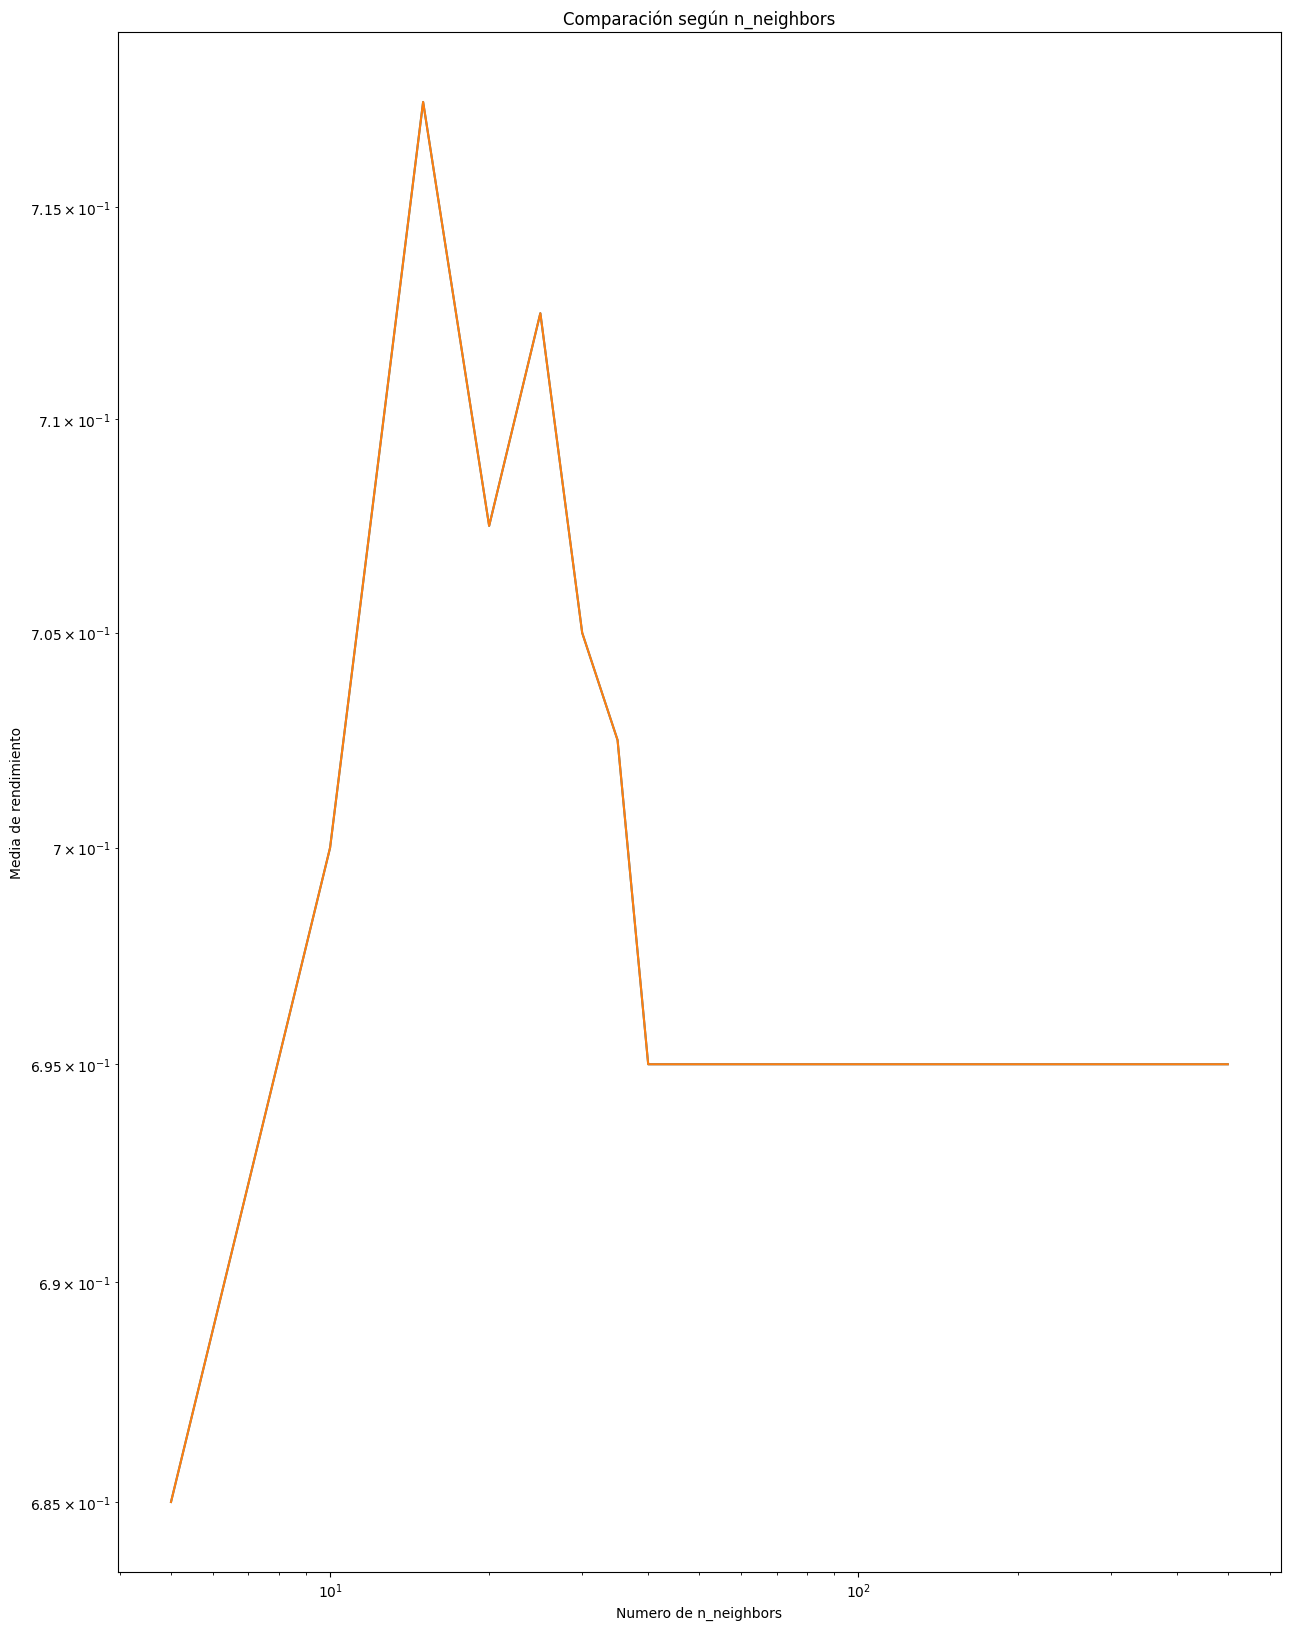


Con n_neighbors = 15 , se tiene una puntuación de 0.7175


In [36]:



number_knn = 100
reps = 40
headers= ["n_neighbors", "Puntuacion media"]
x_val = [i*5  for i in range(1, number_knn+1)]

make_graph_n_table(x_val, x_val, headers, reps)

>Este último print es una aproximación muy vaga del hiperparámetro, debido a que tienen todos puntuaciones muy parecidas, la sección de "Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation" proporciona un mejor valor.


* Utilizando los conceptos de sub- y sobreajuste:
    * Comenta los resultados cuando el número de vecinos es pequeño.
    * Comenta los resultados cuando el número de vecinos es grande.
    * Explica el significado del valor de la precisión cuando el número de vecinos toma el valor mayor posible.
      

Cuando es pequeño (en este caso 5) la puntuación media es bastante peor que con mas vecinos, está subajustado pues no consigue encontrar realmente una diferencia clara entre las distintas áreas de los datos. Al aumentar en 5 los vecinos, la media de rendimiento aumenta notablemente, esto se debe a que el numero de vecinos actua como un "smoothing parameter" y al aumentarlo, en teoría, da mejores resultados, no obstante, hay valores de k que son más grandes y son subóptimos. Esto se debe a que con demasiados vecinos hay un sobreajuste y el algoritmo empieza a ajustarse a datos más especificos, perdiendo capacidad de predictibilidad.

* ¿Cuál es la mejor precisión que se alcanza con k-nn y para qué k (valor de `n_neighbours`)?
  

Para hallar el valor de k más óptimo, se ha utilizado GridSearchCV, que trata de estimar el mejor valor para un parametro (ejecución unas celdas más arriba). En este caso la estimación es de k = 7, lo cual coincide con la gráfica y la tabla.

* ¿Cuál es la mejor precisión que se alcanza con un árbol de decisión y con qué profundidad máxima (valor de `max_depth`)? Para ello, haz una gráfica que muestre la dependencia de la precisión con la profundidad máxima del árbol. Comenta los resultados.
  

 max_depth  Puntuacion media
         5          0.737875
        10          0.686500
        15          0.681500
        20          0.681625
        25          0.682562
        30          0.679562
        35          0.682813
        40          0.681688
        45          0.682312
        50          0.681375
        55          0.681000
        60          0.681000
        65          0.681312
        70          0.681250
        75          0.680813
        80          0.681438
        85          0.681375
        90          0.683500
        95          0.680000
       100          0.680250
       105          0.681438
       110          0.683813
       115          0.682000
       120          0.679937
       125          0.681688
       130          0.682438
       135          0.683750
       140          0.680063
       145          0.679000
       150          0.681063
       155          0.679625
       160          0.680500
       165          0.681000
       170    

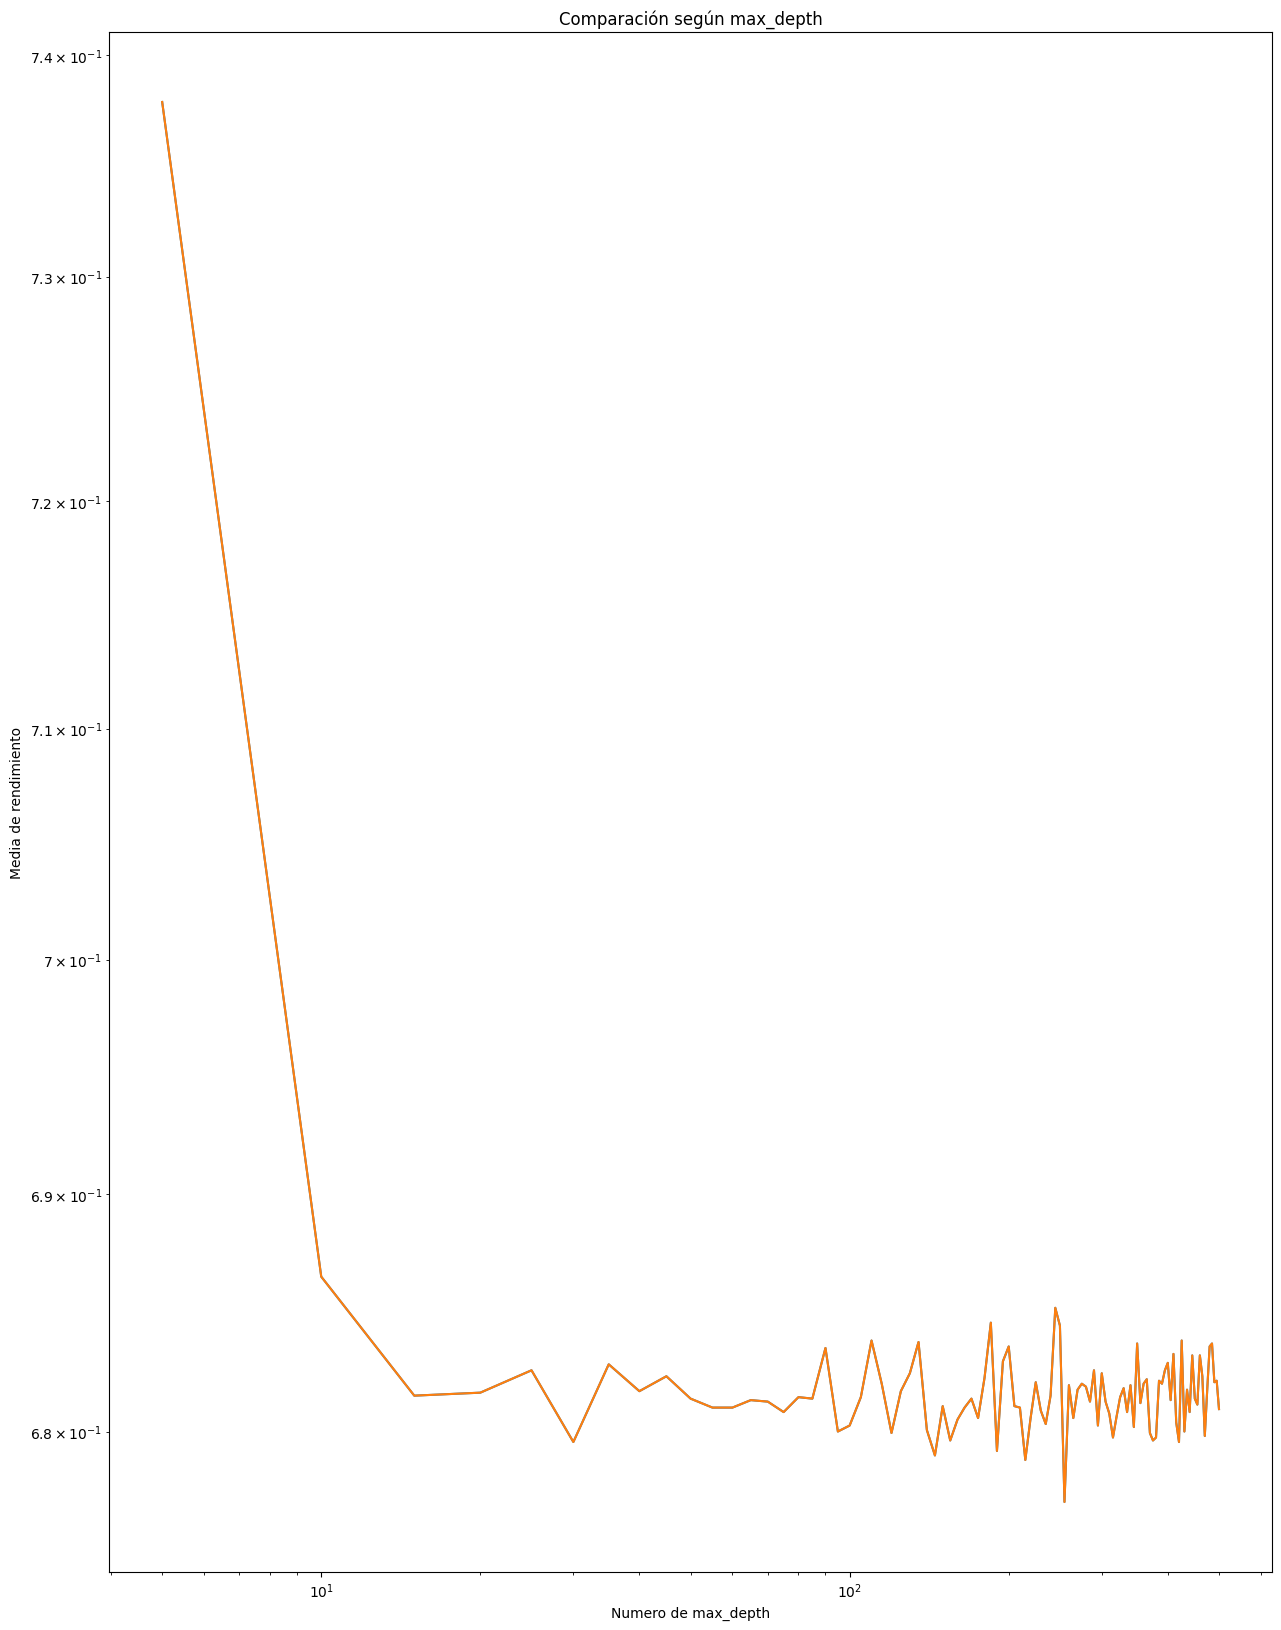


Con max_depth = 5 , se tiene una puntuación de 0.7378750000000001


In [35]:
number_depth = 100

x_val = [i*5  for i in range(1, number_depth+1)]



headers= ["max_depth", "Puntuacion media"]
reps = 40

make_graph_n_table(x_val, x_val, headers, reps)



>Este último print es una aproximación muy vaga del hiperparámetro, debido a que tienen todos puntuaciones muy parecidas, la sección de "Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation" proporciona un mejor valor.
    
Tal y como muestra la gráfica, una profundidad superior a 5 parece poco eficiente, lo que invita a pensar que para este conjunto de datos es mejor mantener el número de vecinos por debajo del 5.

* ¿Cuál es la mejor precisión que se alcanza con una red neuronal con una sola capa oculta y con qué configuración (valor de `hidden_layer_sizes`)? Para ello, haz una gráfica que muestre la dependencia de la precisión con el número de nodos en la capa oculta. Comenta los resultados.

 hidden_layer_sizes  Puntuacion media
                  1          0.702875
                  2          0.715750
                  3          0.733812
                  4          0.745875
                  5          0.742812
                  6          0.750313
                  7          0.755000
                  8          0.755563
                  9          0.759312
                 10          0.751375
                 11          0.754625
                 12          0.754312
                 13          0.754375
                 14          0.755062
                 15          0.753812
                 16          0.754125
                 17          0.754062
                 18          0.756125
                 19          0.753125
                 20          0.754250
                 21          0.754375
                 22          0.755312
                 23          0.750875
                 24          0.753938
                 25          0.751750
            

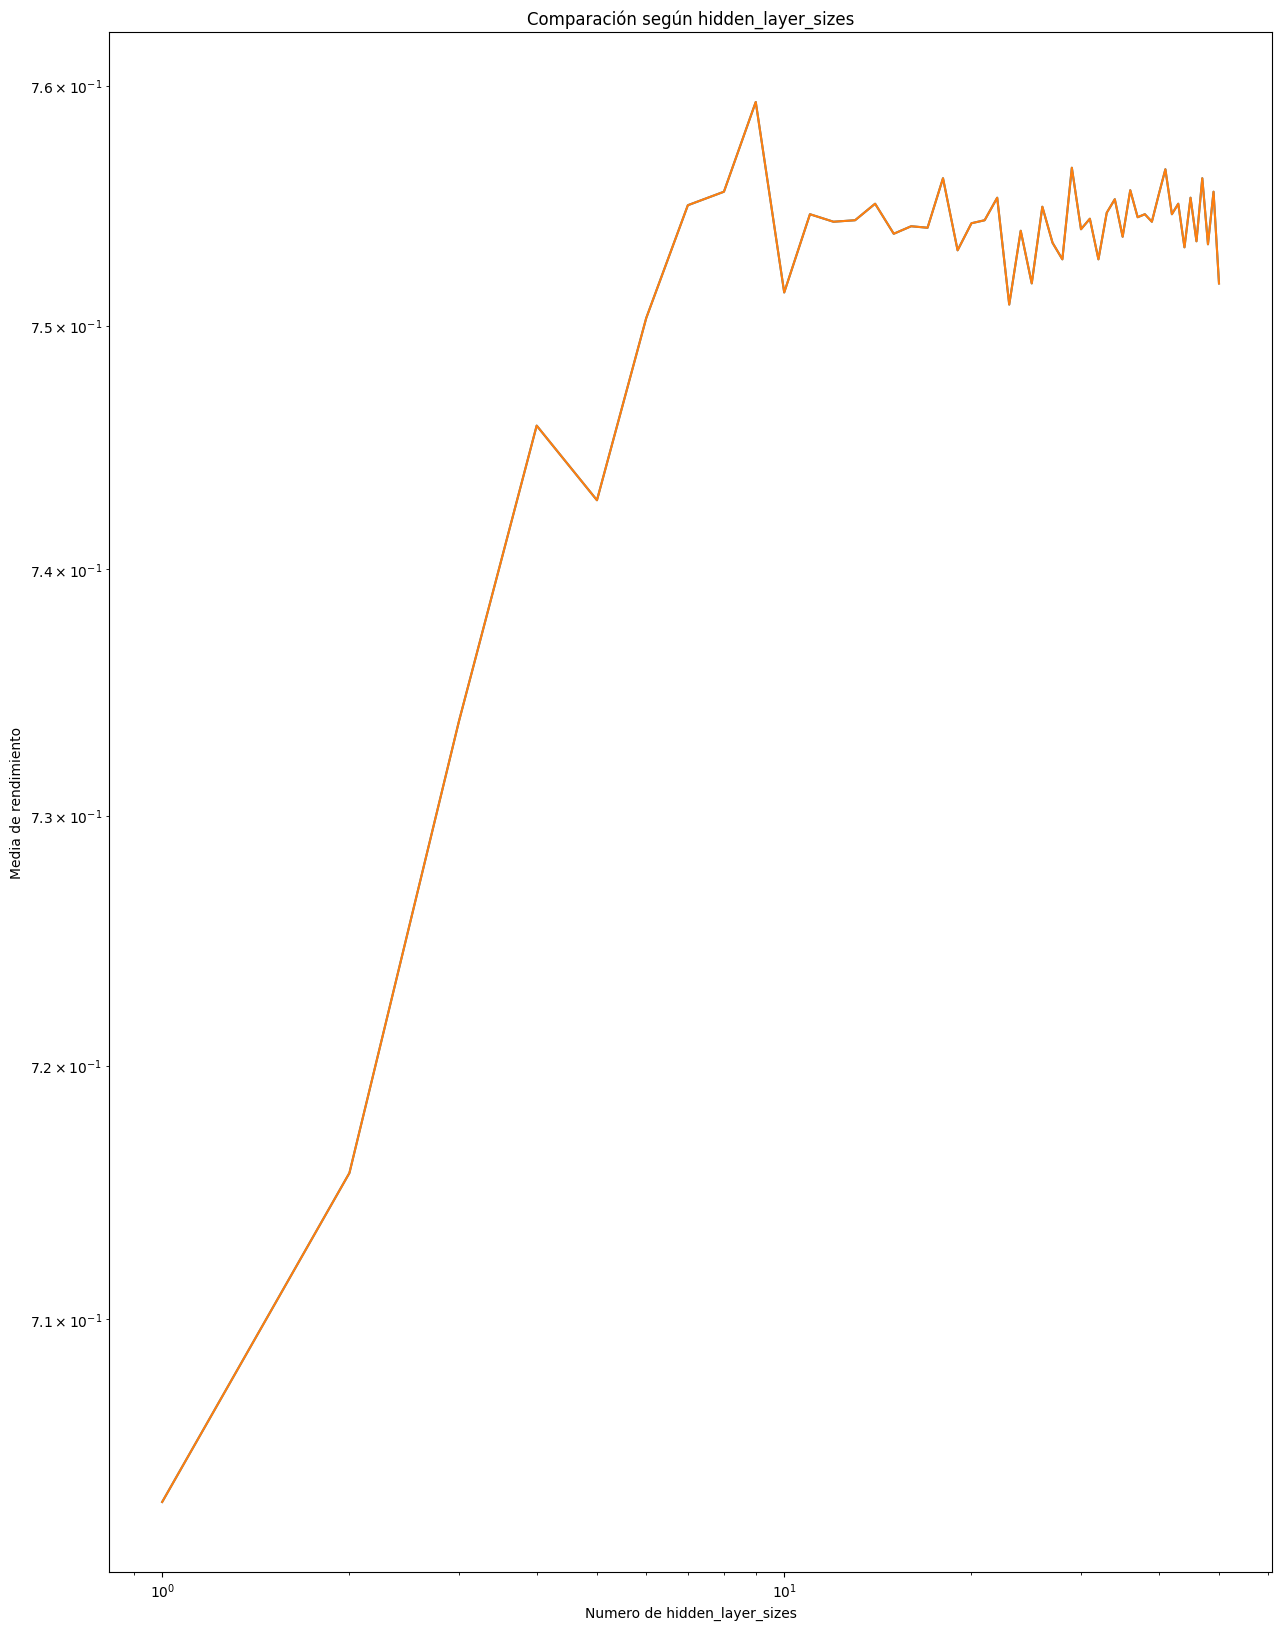


Con hidden_layer_sizes = (9,) , se tiene una puntuación de 0.7593125


In [43]:

number_neurons = 50
reps = 40

x_val = [(i,) for i in range(1, number_neurons+1)]
x_val_graph = [i for i in range(1, number_neurons+1)]

headers= ["hidden_layer_sizes", "Puntuacion media"]

make_graph_n_table(x_val, x_val_graph, headers, reps)


>Este último print es una aproximación muy vaga del hiperparámetro, debido a que tienen todos puntuaciones muy parecidas, la sección de "Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation" proporciona un mejor valor.

Como se puede ver, la puntuación mejora hasta 6 - 7 neuronas, a partir de ahi realmente no hay mucha diferencia mas allá del coste de entrenamiento. Por ende para este modelo, todas las redes con una capa oculta de entre 6 y 50 neuronas tienen una puntuación entorno a 0,75.

* ¿Cuál es la mejor precisión que se alcanza con una red neuronal con varias capas ocultas y con qué configuración? Para ello, haz una gráfica que muestre la dependencia de la precisión con el número de capas ocultas, suponiendo constante el número de nodos en cada capa oculta. Comenta los resultados.
* Resume los resultados y conclusiones del estudio realizado.

**Además de gráficas, puede ser conveniente presentar los resultados en forma de tablas.**

 hidden_layer_sizes  Puntuacion media
                  1          0.750875
                  2          0.754188
                  3          0.752125
                  4          0.744500
                  5          0.750000
                  6          0.741625
                  7          0.744563
                  8          0.738437
                  9          0.741625
                 10          0.737250



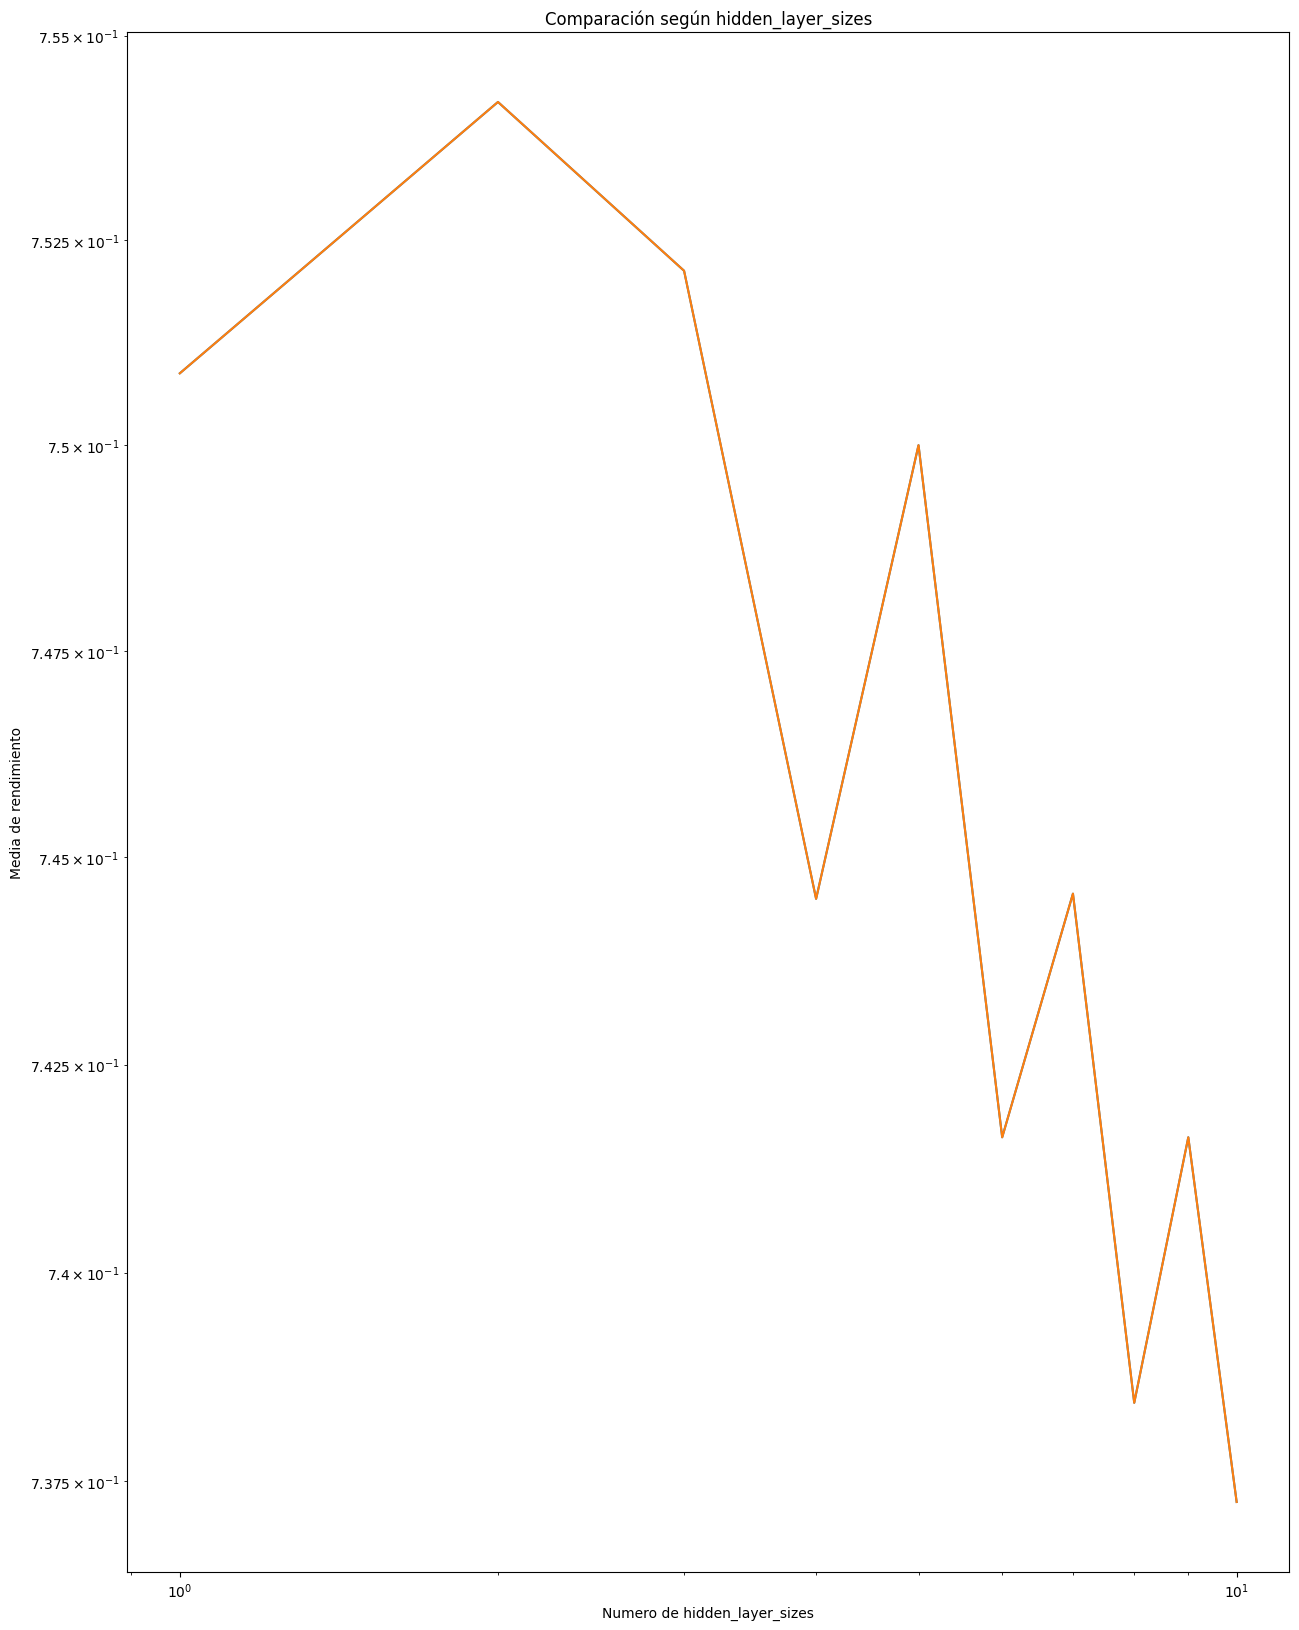


Con hidden_layer_sizes = (10, 10) , se tiene una puntuación de 0.7541875


In [32]:
number_layers = 10
reps = 40

x_val = [(10,)*i for i in range(1, number_layers+1)]
x_val_graph = [i for i in range(1, number_layers+1)]

headers= ["hidden_layer_sizes", "Puntuacion media"]

make_graph_n_table(x_val, x_val_graph, headers, reps)


> Este último print es una aproximación muy vaga del hiperparámetro, debido a que tienen todos puntuaciones muy parecidas, la sección de "Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation" proporciona un mejor valor.
    
Con una capa, se obtiene algo más de puntuación, habiendo en este parámetro algo más de diferencia. 

Se puede afirmar que más neuronas de las necesarias en la capa, no penalizan al estimador, pero si aumentan el costo de entrenamiento. Asímismo, más capas si que pueden llegar a afectar a la puntuación además de añadir más tiempo de entrenamiento.

## Procesamiento

En ocasiones, en lugar de utilizar modelos más complejos, es más útil invertir más tiempo en el procesamiento de los datos para conseguir mejores resultados.

En este apartado vas a investigar mecanismos para preparar los datos y obtener (en principio) mejores resultados: construcción y selección de atributos, preprocesamiento (detección de outliers, missing values, centrado y escalado).

Razona por qué decides probar o ignorar alguno de estos métodos, y cómo cambian los resultados al aplicarlos (puedes crear tantas celdas como consideres oportunas).
Usa tablas, gráficas y código, según sea necesario, para ilustrar tus observaciones.

In [58]:
data = pd.read_csv('./data/german_credit_data.csv', sep=';')
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
X = df[feature_names].values
y = df[class_label].values
# seleccion de atributos

# Se obtienen los distintos conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


### Construcción y selección de atributos

Los datos son información acerca de los clientes de una sucursal bancaria

#### 1. Analisis conceptual de los atributos:

| Atributo | Definición | Elegido |
|----------|----------|----------|
| default  | Class   | Si   |
| account_check_status    | Tener una cuenta corriente  | Si   |
| duration_in_month   | Haber estado muchos meses   | Si   |
| credit_history   | Haber tenido deudas   | Si   |
| purpose   |  Pedir creditos para distintos bienes | Si   |
| savings   | Ahorros   | Si   |
| credit_amount | La cantidad de crédito | Si |
| present_emp_since   | Tiempo que lleva presente   | Si   |
| installment_as_income_perc   | Pagan algo a plazos  | Si   |
| personal_status_sex   | Estado civil y sexo    | Si   |
| other_debtors   |  No se realmente a que se refiere con otros deudores   |  No  |
| present_res_since   | Tampoco se que es    | No   |
| property   | Las propiedades  | Si   |
| age   |  La edad   | Si   |
| other_installment_plans   | Podía llegar a ser relevante, pero hay muchos missing values | No   |
| housing   | Si tiene casa    | Si   |
| credits_this_bank   | Las deudas con el banco  |  Si  |
| job   |  Los trabajos  | Si   |
| people_under_maintenance   |  Personas a las que mantiene  | Si   |
| telephone   |  El telefono |  No  |
| foreign_worker   |  Trabajador extranjero  |  Si   |
#### 2. Histogramas en panda

    El siguiente código se proporcionaba en el demo_german_credit_data.

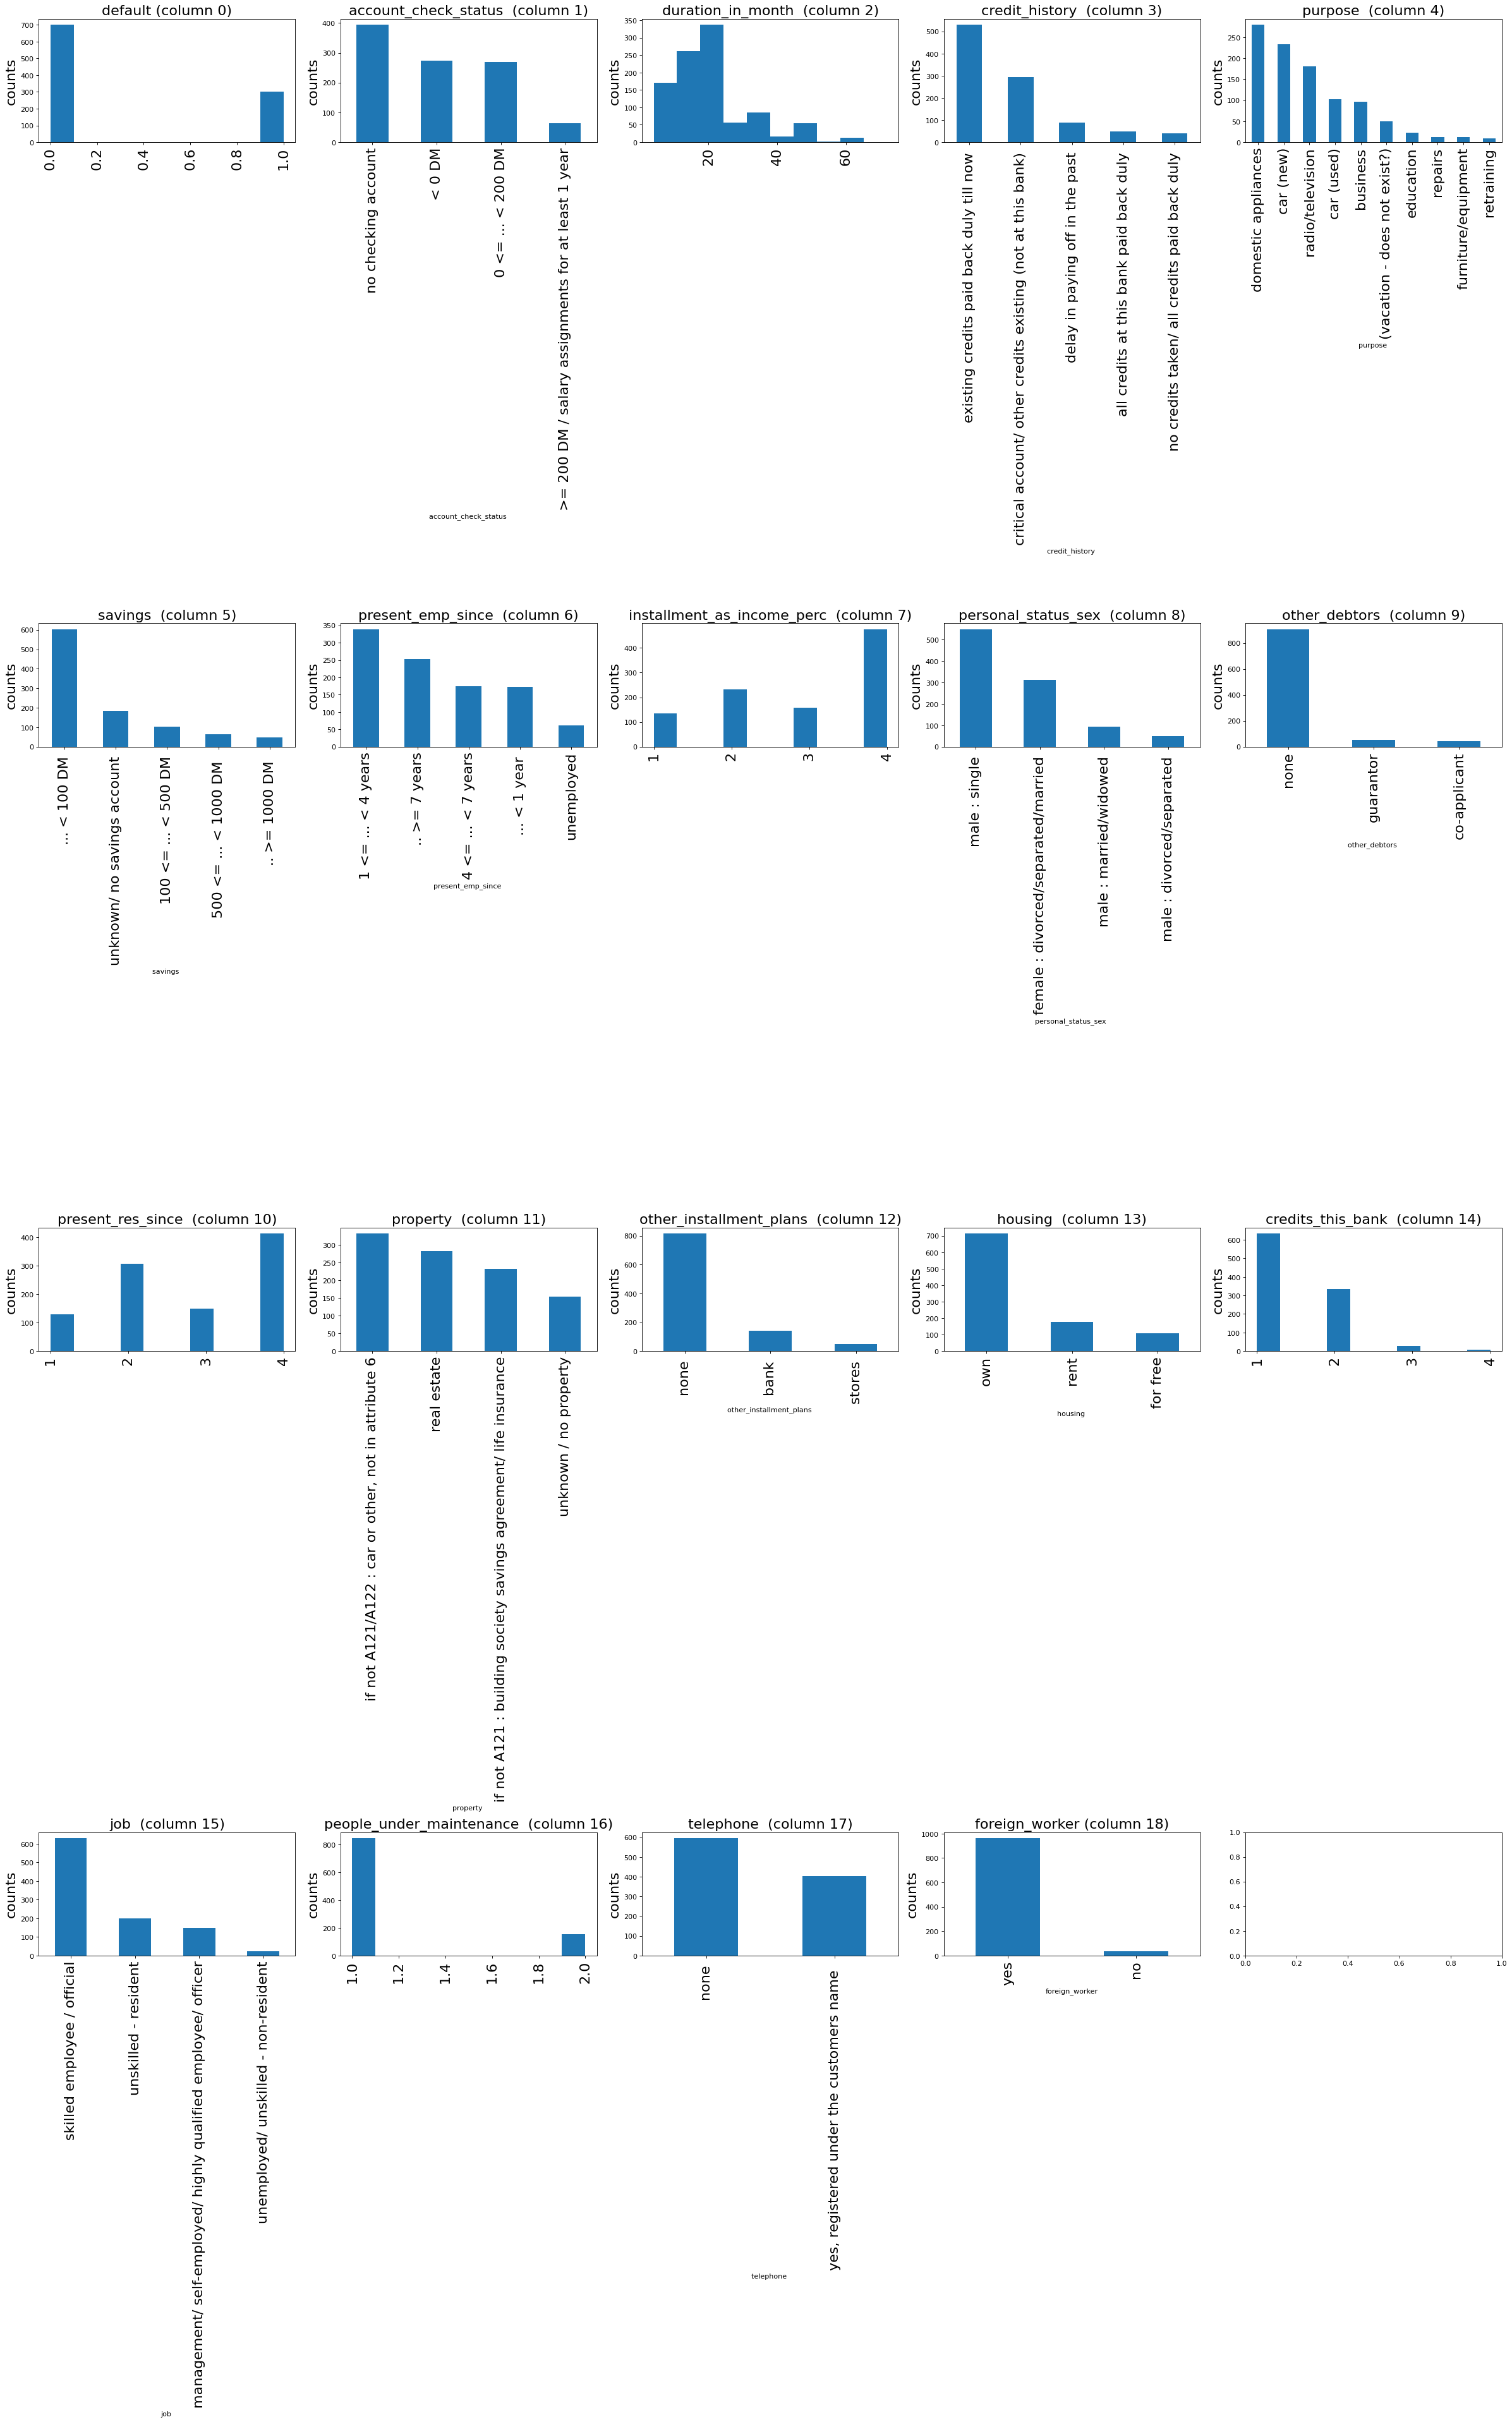

In [25]:

import numpy as np

n_plots_per_row = 5
    
n_unique = data.nunique()

# For displaying purposes, pick attributes that have between 1 and 50 unique values
data_plot = data[[col for col in data if n_unique[col] > 1 and n_unique[col] < 50]] 

n_examples, n_attributes = np.shape(data_plot)
attribute_names = list(data_plot)

n_rows_fig = int(np.ceil((n_attributes - 1) / n_plots_per_row))

fig, axes = plt.subplots(
    nrows=n_rows_fig,
    ncols=n_plots_per_row,
    figsize=(6 * n_plots_per_row, 12 * n_rows_fig), 
    dpi=80, 
    facecolor='w', 
    edgecolor='k',
)

fontsize = 20

for index_attribute in range(n_attributes):
    row_plot, column_plot = np.divmod(index_attribute, n_plots_per_row) 
    ax = axes[row_plot, column_plot]

    values_plot = data_plot.iloc[:, index_attribute]
    if (np.issubdtype(type(values_plot.iloc[0]), np.number)):
        values_plot.plot.hist(ax=ax)
    else:
        values_plot = values_plot.value_counts()
        values_plot.plot.bar(ax=ax)

    # ax.xaxis.set_tick_params(rotation=90)
    ax.tick_params(axis='x', rotation=90, labelsize=fontsize)
    ax.set_ylabel('counts', fontsize=fontsize)
    ax.set_title(
        '{} (column {})'.format(
            attribute_names[index_attribute], 
            index_attribute
        ), 
        fontsize=fontsize,
    )

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.show()

Al generar gráficas de los datos, se puede observar que hay algunos que están más normalizados (como es el caso de property o purpose) y otros que son más atípicos como other debtors.

#### 3.Prueba de atributos

In [48]:
def train_n_score(X, Y, clf, scores, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf.fit(X_train,  y_train)    
    if name not in scores.keys():
        scores[name] = dict()
    
    scores[name][i] = clf.score(X_test, y_test)


scores = dict()

for i in df.columns:
    if i != "Class":
        X = df[i].values
        X = np.array(X)
        X = X.reshape(-1, 1)
        
        name = "Naive Bayes"
        clf = GaussianNB(var_smoothing= 0.00032) 
        train_n_score(X, y, clf, scores, name)
        
        name = "Knn Neighbors"
        clf = KNeighborsClassifier(n_neighbors = 14) 
        train_n_score(X, y, clf, scores, name)
    
        name = "Decision Tree"
        clf = DecisionTreeClassifier(max_depth = 4) 
        train_n_score(X, y, clf, scores, name)
        
        name = "Logistic regresion"
        clf = LogisticRegression(tol =  1.0, solver =  'lbfgs', max_iter =  1000, penalty =  'l2') 
        train_n_score(X, y, clf, scores, name)
    
        name = "Neural Network"
        clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=10000,alpha=0.0)
        train_n_score(X, y, clf, scores, name)

In [49]:
for i in scores:
    print("For", i, end="")
    high = 0
    best_key = ""
    for key, value in scores[i].items():
        if value>high:
            high = value
            best_key = key

    print("Best atribute is", best_key, "with a score of", high)

For Naive BayesBest atribute is X3 with a score of 0.716
For Knn NeighborsBest atribute is X3 with a score of 0.716
For Decision TreeBest atribute is X3 with a score of 0.712
For Logistic regresionBest atribute is X3 with a score of 0.712
For Neural NetworkBest atribute is X3 with a score of 0.712


El atributo con mejor puntuación en todos los modelos es el X3, por lo que, como se ha supuesto antes, parece que aquellos atributos que se asemejan a alguna distribución en su gráfica, otorgan mayor capacidad de predictibilidad.


### Preprocesamiento

#### Outlier detection

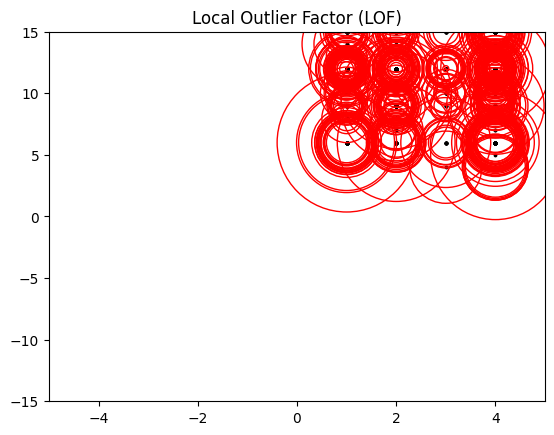

In [82]:
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# radio del circulo
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=10000* radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-15, 15))

plt.title("Local Outlier Factor (LOF)")
plt.show()

A través de la función LocalOutlierFactor, se pueden obtener los Outliers scores, es decir la desviación de la densidad local. En el caso del dataset dado, como se puede apreciar hay muchos outliers. Es importante tenerlos en cuenta porque modifican la predictibilidad de un dato

#### Missing Values

No parece que falten valores en el conjunto de datos, pero la idea sería utilizar SimpleImputer de sklearn.impute para añadir medias en los valores restantes.

In [28]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
X = df[feature_names].values
y = df[class_label].values

#### Estandarización 

In [29]:

# preprocesamiento - estandarización
# se estandariza el data set
# mirar pagina
scaler = preprocessing.StandardScaler()

X_train_selected = scaler.fit_transform(X_train)

X_test_selected = scaler.transform(X_test)


scaler_scores= list()
no_scaler_scores= list()

for i in range(40):
    
    clf = MLPClassifier(hidden_layer_sizes=(9,9,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_train_selected, y_train)
        
    y_pred = clf.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    scaler_scores.append(scores)

    
    clf2 = MLPClassifier(hidden_layer_sizes=(9,9,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf2.fit(X_train_selected, y_train)
        
    y_pred = clf2.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    no_scaler_scores.append(scores)
    
print("Con StandardScaler ", mean(scaler_scores), "\nSin StandardScaler", mean(no_scaler_scores))


Con StandardScaler  0.6938124999999999 
Sin StandardScaler 0.69625


In [30]:
# preprocesamiento - estandarización
# se estandariza el data set

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

X_train_selected = scaler.fit_transform(X_train)

X_test_selected = scaler.transform(X_test)

scaler_scores= list()
no_scaler_scores= list()

for i in range(40):
    
    clf = MLPClassifier(hidden_layer_sizes=(9,9,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_train_selected, y_train)
        
    y_pred = clf.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    scaler_scores.append(scores)

    
    clf2 = MLPClassifier(hidden_layer_sizes=(9,9,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf2.fit(X_train_selected, y_train) # entrenamiento
        
    y_pred = clf2.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    no_scaler_scores.append(scores)
    
print("Con MinMaxScaler ", mean(scaler_scores), "\nSin MinMaxScaler", mean(no_scaler_scores))

Con MinMaxScaler  0.7136875 
Sin MinMaxScaler 0.711875


Parece que no hay mucha diferencia, esto puede ser porque aquellos datos que no están estandarizados en este modelo de datos, igual no tienen mucho peso sobre la clase.

## Hiperparámetros


¿Cómo se determina el valor de los hiperparámetros?

Para determinar el valor de los hiperparámetros de un modelo realizaremos una búsqueda en una rejilla. De entre los valores considerados seleccionaremos los que maximicen la estimación por validación cruzada (K = 10) de la tasa de acierto.

Adapta el código que encontrarás en 
[https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)
a este problema. 

En los tutoriales
[https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html](
    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
[https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
hay información sobre cada uno de los hiper-parámetros. 
Puedes elegir el conjunto de hiperparametros en el que se realiza la optimización. 
Antes de elegir la rejilla de hiperparámetros, asegúrate de que entiendes su para asegurarte que tiene sentido la búsqueda.

In [39]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7
    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]


    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std



    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict

    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index
 

# ----------------------------------------------------------

from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)



scores = ["precision", "recall"]

best = list()

max_knn = 100
tuned_parameters = [{"n_neighbors": [i for i in range(1,max_knn)]}]

grid_search = GridSearchCV(
    KNeighborsClassifier(), tuned_parameters , scoring=scores, refit=refit_strategy, cv=10
)
grid_search.fit(X, y)
best.append("KNeighborsClassifier" + str(grid_search))
print()


max_max_depth = 100
tuned_parameters= [{"max_depth": [i for i in range(1,max_max_depth)]}]
grid_search = GridSearchCV(
    DecisionTreeClassifier(), tuned_parameters, scoring=scores, refit=refit_strategy, cv=10
)
grid_search.fit(X_train, y_train)
best.append("DecisionTreeClassifier" + str(grid_search))
print()




All grid-search results:
precision: 0.756 (±0.035), recall: 0.769 (±0.053), for {'n_neighbors': 1}
precision: 0.733 (±0.021), recall: 0.927 (±0.021), for {'n_neighbors': 2}
precision: 0.753 (±0.024), recall: 0.827 (±0.040), for {'n_neighbors': 3}
precision: 0.731 (±0.019), recall: 0.924 (±0.028), for {'n_neighbors': 4}
precision: 0.744 (±0.026), recall: 0.850 (±0.039), for {'n_neighbors': 5}
precision: 0.724 (±0.019), recall: 0.934 (±0.035), for {'n_neighbors': 6}
precision: 0.750 (±0.019), recall: 0.879 (±0.036), for {'n_neighbors': 7}
precision: 0.724 (±0.015), recall: 0.936 (±0.036), for {'n_neighbors': 8}
precision: 0.734 (±0.018), recall: 0.897 (±0.045), for {'n_neighbors': 9}
precision: 0.719 (±0.014), recall: 0.947 (±0.022), for {'n_neighbors': 10}
precision: 0.734 (±0.015), recall: 0.916 (±0.031), for {'n_neighbors': 11}
precision: 0.723 (±0.016), recall: 0.954 (±0.021), for {'n_neighbors': 12}
precision: 0.729 (±0.016), recall: 0.927 (±0.033), for {'n_neighbors': 13}
precision

Como se puede comprobar la ejecución respalda las gráficas presentadas previamente sobre n_neighbors y max_depth encontrandose estos valores óptimos en picos altos de puntuación.

## ¿Cómo se estima el error de generalización?

Estimaremos el error de generalización de cada clasificador usando *Nested Cross Validation*. 


Adapta el código que encontrarás en https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html para resolver este problema con una red neuronal. 


Average difference of 0.033889 with std. dev. of 0.009061.


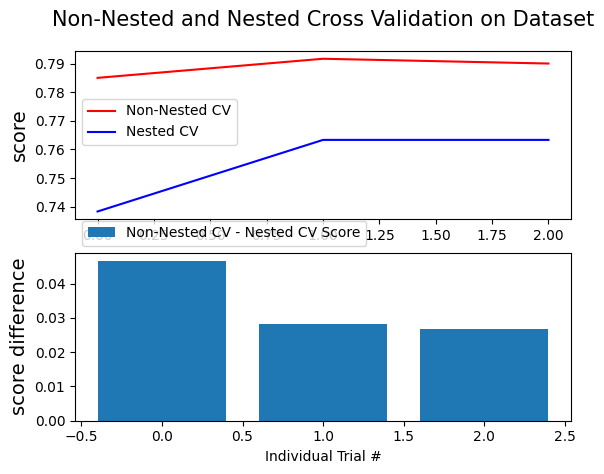

In [46]:

# Number of random trials
NUM_TRIALS = 3

# Load the dataset
X_iris = X_train
y_iris = y_train

# Set up possible values of parameters to optimize over
# Se sabe que por ecima de 3 capas para este conjunto se pierde precisión, y que hay 2 
# picos de precisión en el número de neuronas aunque sea por muy poca diferencia
p_grid = {"hidden_layer_sizes": [(10,), (10,10,), (10,10,10,), (70,), (10,70,), (10,70,10,), (70,70,70,)], 
          "learning_rate":["constant", "invscaling", "adaptive"]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = MLPClassifier(max_iter=3000,alpha=0.0)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

## ¿Cuál es el mejor clasificador?

* De acuerdo con los resultados de los anteriores apartados, indica cuál es el mejor clasificador encontrado.

    Todo parece indicar, que para este modelo de datos el clasificador más óptimo es MLPClassifier (redes neuronales), las redes neuronales son óptimas para la mayoría de modelos que tienen un volumen de datos medianamente aceptable. 


* ¿Cuáles son los valores de los hiperparámetros utilizados para configurar y entrenar tal clasificador?

    El número de neuronas por capa es 10, el número de capas es 2 y de iteraciones se ha tenido que poner 9000 para que no saltasen warnings de convergencia.
  

* ¿cuáles son los valores de los parámetros del clasificador entrenado?

    La red neuronal tiene una precisión del 0.77 con una desviación estándar de +/- 0.01


* Proporciona una estimación del error de generalización por validación cruzada, así como de la incertidumbre de dicha estimación.

    Como se puede ver en la gráfica superior, mas o menos hay un 0.033889 de diferencia de error, pero este podría ser mayor o menor, en las ejecuciones realizadas tiene una desviación estandar de 0.009061. Hay que tener en cuenta, que en un data set muy grande, habrá conjuntos de datos de train que puede ser que favorezcan mucho a la previsión y conjuntos que no. Por ende, se pueden dar casos en los que el modelo esta bien entrenado (conjuntos de datos en train favorable) y casos en los que no (conjuntos de datos en train que no son favorables o bien por no tener una buena relación con la clase o bien por ser demasiado especificos).

## Conclusiones.

Primero se ha empezado analizando los distintos tipos de estimadores, buscando através de GridSearchCV el valor de los hiperparámetros de cada estimador, para hallar su rendimiento promedio (a través de cross_validation) y su desviación estandar. En dicha sección se ha concluido que las redes neuronales eran óptimas para este modelo de datos. 

Tras esto, se han realizado gráficas sobre los parámetros n_neighbors, max_depth y hidden_layer_sizes, realizando en este último dos gráficas, una para el tamaño de las neuronas y otra para el número de capas ocultas. En estas se ve reflejado (aunque de manera un poco imprecisa) también el valor del hiperparámetro. Quizas la conclusión más interesante de ver es respecto al número de neuronas y capas de las redes neuronales, pues como se ha comentado previamente en el pie de la gráfica, un exceso de neuronas no repercute en el rendimiento pero uno de capas sí.

La tercera sección es sobre el análisis y procesamiento de datos, aquí se han analizado los datos de diversas maneras, primero a nivel conceptual (en el que se deja claro si se habrían utilizado los datos si se pasase a numérico el csv de nuevo) y luego mediante histogramas y una ejecución de estimadores sobre los atributos por separado; de esto se pde concluir que si el atributo sigue de manera aproximada una distribución y está relacionado de una manera medianamente fuerte con la clase, la red neuronal tendrá más efectividad. Tras esto se han observado los "outliers" o valores atípicos del modelo (se ha usado un código proporcionado en la documentación de sklearn) que parecen ser bastantes. Luego de esto, se ha tratado de estandarizar el modelo pero no ha parecido suponer un gran cambio. Para terminar, se han buscado los hiperparámetros de nuevo, pero esta vez con el código de sklearn proporcionado y sobre los estimadores pedidos (que encajan a la perfección con las tablas y las gráficas de ambos estimadores), y se ha estimado el error de generalización planteando una idea sobre porque puede suceder.



